<a href="https://colab.research.google.com/github/doxenix/INL/blob/main/projekt_NER_Dominik_Zalewski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt z NLP: rozpoznawanie nazw własnych w języku polskim (NER)
autor: Dominik Zalewski

indeks: s24216

W ninijeszym projekcie zaprezentuje moje rozwiązanie w temacie rozpoznawania nazw własnych w języku polskim. Nasze dane treningowe to NKJP_org. Moje rozwiązanie opieram o wytrenowanie dwóch modeli opartych o sieci neuronowe. Zrobimy to od "zera", nie używając wytrenowanych już wcześniej modeli (tzw. "transfer learing")

Środowiskiem w którym należy uruchomić notatnik jest Google Colab.

## Przygotowanie środowiska w Colab

Zacznijmy od uruchomienia poniższej komórki. Potrzebujemy dwóch rzeczy:

* Zainstalować bibliotekę `stop_words`
* Doinstalować model `pl_core_news_sm` do pakietu spacy. Będzie nam to potrzebne w procesie lematyzacji
* a także moduł `keras-tuner` skorzystamy z niego przy hypertuningu parametrów

I to właśnie zrobimy uruchamiając komórke poniżej:


In [ ]:
!pip install stop_words
!python -m spacy download pl_core_news_sm

Kolejnym krokiem jest oczywiście import bibliotek:

In [2]:
import pandas as pd
import numpy as np
import csv
import warnings

from stop_words import get_stop_words
import spacy

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM,
    Embedding,
    Dense,
    TimeDistributed,
    SpatialDropout1D,
    Bidirectional
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import ast

warnings.filterwarnings("ignore")

# increase limit for reading csv data
csv.field_size_limit(100000000)

131072

## Przygotowanie danych

Zacznijmy od pobrania danych NKJP_org.csv

Po pobraniu, wczytamy dane za pomocą funkcji `read_csv_data()` z odpowiednimi parametrami. Wyjątkowo dużo parametrów ze względu na specifikę pliku csv, to nam umożliwi poprawne wczytanie danych.



In [3]:
!wget https://raw.githubusercontent.com/doxenix/INL/main/NKJP_org.csv

--2022-12-24 12:45:20--  https://raw.githubusercontent.com/doxenix/INL/main/NKJP_org.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24288720 (23M) [text/plain]
Saving to: ‘NKJP_org.csv’

NKJP_org.csv        100%[===================>]  23.16M  --.-KB/s    in 0.1s    

2022-12-24 12:45:21 (211 MB/s) - ‘NKJP_org.csv’ saved [24288720/24288720]



In [4]:
def read_csv_data(path, col_names):
    raw_data = pd.read_csv(
        path,
        sep="\t",
        encoding="UTF-8",
        header=None,
        names=col_names,
        engine="python",
        quotechar='"',
        error_bad_lines=False,
        skip_blank_lines=False,
    )

    return raw_data


col_names = ["forma", "lemat", "tag", "etykieta"]
raw_data = read_csv_data("/content/NKJP_org.csv", col_names)
raw_data

Skipping line 476905: '	' expected after '"'
Skipping line 481586: '	' expected after '"'
Skipping line 587296: unexpected end of data


,forma,lemat,tag,etykieta
0,Zatrzasnął,praet:sg:m1:perf,None,None
1,drzwi,subst:pl:acc:n:pt,None,None
2,od,prep:gen:nwok,None,None
3,mieszkania,subst:sg:gen:n:ncol,None,None
4,",",interp,None,None
...,...,...,...,...
587288,Szalone,adj:sg:acc:n:pos,None,None
587289,życie,subst:sg:acc:n:ncol,None,None
587290,Rudolfa,subst:sg:gen:m1,persName,forename
587291,\tinterp\n\nExtra\tadj:sg:nom:n:pos\n!\tinterp...,interp,None,None


Tak wyglądaja nasze surowe dane. Przed nami sporo pracy - dane musimy odpowiednio przygotować.

Zaczniemy od lematyzacji każdego słowa. Wykorzystamy bibliotekę spacy i gotowy model `pl_core_news_sm`. Niestety odaplając funkcję poniżej jesteśmy zmuszeni długo poczekać. Ja oczywiście już to zrobiłem wcześniej, z tej racji można przejść kilka komórek niżej - czyli pominąć proces lematyzacji i obróbki danych. Gotowe dane zapisałem do nowego pliku i poźniej jest pobierany. Aby przejść do tego momentu w Spisie treści kliknąć podroździał `OPCJONALNIE - pobranie obrobionych danych`

Aby przygotować dane zostały wykonane następujące kroki:

* lematyzacja 
* usunięcie słów tzw. stop words
* usunięcie znaków interpunkcyjnych 
* stworzenie poprawnej kolumny z tagiem dla każdego słowa za pomocą funkcji `create_clean_tag_column`




In [ ]:
nlp = spacy.load("pl_core_news_sm")


def lemmatize_word(word):
    if not pd.isna(word):
        doc = nlp(word)
        for token in doc:
            lemmatized_token = token.lemma_
        return lemmatized_token


raw_data["forma"] = raw_data["forma"].map(lemmatize_word)

In [ ]:
def remove_stop_words(df):

    stop_words = get_stop_words("polish")
    df = df[~df["forma"].isin(stop_words)]

    return df


raw_data = remove_stop_words(raw_data)

In [ ]:
def remove_interp_chars(df):
    df = df.loc[~(df["lemat"] == "interp")]

    return df


def create_clean_tag_column(df):

    df.etykieta.fillna(df.tag, inplace=True)
    df[["tag", "etykieta"]] = df[["tag", "etykieta"]].applymap(
        lambda x: "O" if pd.isnull(x) else x
    )

    df[["tag", "etykieta"]] = df[["tag", "etykieta"]].applymap(
        lambda x: "O" if pd.isnull(x) else x
    )

    df.drop("lemat", axis=1, inplace=True)
    df.drop("tag", axis=1, inplace=True)

    return df


clean_data = remove_interp_chars(raw_data)
clean_data = create_clean_tag_column(clean_data)

In [ ]:
clean_data['etykieta'].value_counts()

O             382308
surname         6647
forename        6613
orgName         4960
country         3975
settlement      3813
geogName        1994
date            1973
persName         571
addName          447
region           290
time             193
district         182
placeName        140
bloc              59
Name: etykieta, dtype: int64

In [ ]:
clean_data['etykieta'].value_counts(normalize=True)

O             0.923081
surname       0.016049
forename      0.015967
orgName       0.011976
country       0.009598
settlement    0.009206
geogName      0.004815
date          0.004764
persName      0.001379
addName       0.001079
region        0.000700
time          0.000466
district      0.000439
placeName     0.000338
bloc          0.000142
Name: etykieta, dtype: float64

Powyżej możemy wstępnie podejrzeć jak wygląda rozkład naszych tagów. Zdecydowanie przeważa tutaj tag `O` - czyli ten który wskazuje na zwykłe słowo niebędące nazwą własną - to jest aż 92% wszystkich słów w naszym zbiorze.

Łącznie mamy 15 unikalnych tagów -  to sporo każdy poza `O` symbolizuje nazwę własną jednak o innym charaketerze. Przykładowo tagi których stosunek do wszystkich wystąpień tagów przekracza 1% to:

* `surname` - czyli nazwisko
* `forename` - czyli imię
* `orgName` - nazwa własna np. nazwa organziacji/firmy

Na koniec musimy pogrupować nasze dane tak aby z rozdzielonych słów zbudować wiersze z pełnymi zdaniami. Umożliwi to nam pusta przerwa między nowymi zdaniami. To samo zrobimy dla kolumny z tagami i zamienimy do listy. Sprawdźmy poniżej jak będą wyglądać nasze dane po tym zabiegu.

In [ ]:
def group_sentences(df):

    df["zdanie"] = 1
    df["zdanie"] = df["forma"].isnull().cumsum()

    df = df[df["forma"].notna()]

    aggr_sentences = (
        df.groupby(["zdanie"])["forma"].apply(lambda x: " ".join(x)).reset_index()
    )
    return aggr_sentences


def group_tags(df):
    aggr_tokens = (
        df.groupby(["zdanie"])["etykieta"].apply(lambda x: " ".join(x)).reset_index()
    )
    aggr_tokens["etykieta"] = aggr_tokens["etykieta"].str.split(" ")

    return aggr_tokens


def merge_dfs(df_1, df_2, on, how):

    sentences_df = df_1.merge(df_2, on=on, how=how)

    return sentences_df


aggr_sentences = group_sentences(clean_data)
aggr_tokens = group_tags(clean_data)
sentences_df = merge_dfs(df_1 = aggr_sentences, df_2 = aggr_tokens, on = 'zdanie', how = 'left')

sentences_df

,zdanie,forma,etykieta
0,0,Zatrzasnął drzwi mieszkania razy przekręcił kl...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,1,Bohaterem powieści Paźniewskiego miasto Krzemi...,"[O, O, O, surname, O, settlement]"
2,2,Jak za czasów Słowackiego funkcjonuje Liceum i...,"[O, O, O, O, surname, O, orgName, O, O, geogName]"
3,3,Krzemieniec powieściowy tamtym Krzemieńcem ale...,"[O, settlement, O, O, settlement, O, O, O, O, ..."
4,4,Swoją drogę tego miasta autor zaczął z daleka,"[O, O, O, O, O, O, O, O, O]"
...,...,...,...
38085,38218,Przedstaw podstawie wybranych utworów literack...,"[O, O, O, O, O, O, O, O, O]"
38086,38219,Rozważ problem wybranych przykładach literacki...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
38087,38220,Wyróżniającą cechą szamana niezależnie kultury...,"[O, O, O, O, O, O, O, O, O, O]"
38088,38221,Ani wiedza ani zrozumienie ani też bierna akce...,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"


## OPCJONALNIE - pobranie obrobionych danych

W tym miejscu kontynuacja jeśli nie wykonaliśmy powyższych kroków. Tak naprawdę możemy zacząć od tego miejsca od zera (wcześniej tylko importy bibliotek i instalacja - 1 i 2 komórka)

Pobieramy oczyszczone i przygotowane dane, a następnie je wczytujemy. Biblioteka ast umozliwi nam konwersję string do listy.

In [5]:
!wget https://raw.githubusercontent.com/doxenix/INL/main/clean_data_with_lemma.csv

--2022-12-24 12:45:54--  https://raw.githubusercontent.com/doxenix/INL/main/clean_data_with_lemma.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5179828 (4.9M) [text/plain]
Saving to: ‘clean_data_with_lemma.csv’

clean_data_with_lem 100%[===================>]   4.94M  --.-KB/s    in 0.05s   

2022-12-24 12:45:55 (102 MB/s) - ‘clean_data_with_lemma.csv’ saved [5179828/5179828]



In [6]:
def read_preprocessed_data(path):
    df = pd.read_csv(path)
    df["etykieta"] = df["etykieta"].apply(lambda x: ast.literal_eval(x))

    return df


sentences_df = read_preprocessed_data("clean_data_with_lemma.csv")
sentences_df

,zdanie,forma,etykieta
0,0,zatrzasnąć drzwi mieszkanie raz przekręcić klu...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,1,Bohater powieść paźniewskiy miasto krzemieniec,"[O, O, surname, O, settlement]"
2,2,jak za czas Słowacki funkcjonować liceum i pły...,"[O, O, O, surname, O, orgName, O, O, geogName]"
3,3,krzemieniec powieściowy tamto Krzemieńcem ale ...,"[settlement, O, O, settlement, O, O, O, O, O, ..."
4,4,swój droga to miasto autor zacząć z daleki,"[O, O, O, O, O, O, O, O]"
...,...,...,...
38085,38218,Przedstaw podstawa wybrać utwór literacki czło...,"[O, O, O, O, O, O, O, O]"
38086,38219,Rozważ problem wybrać przykład literacki wizja...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
38087,38220,Wyróżniającą cecha szamać niezależnie kultura ...,"[O, O, O, O, O, O, O, O, O]"
38088,38221,ani wiedza ani zrozumienie ani też bierny akce...,"[O, O, O, O, O, O, O, O, O, O, O, O]"


Tak prezentują się nasze gotowe dane. To jednak nie koniec. Zależy nam aby dane były jak najlepszej jakości. Zweryfikujemy teraz poprawność dopasowań słów do tagu w każdym zdaniu czyli każdym wierszu:

In [7]:
def check_num_equal_rows(df):

    df["list_sentence"] = df["forma"].apply(lambda x: x.strip().split(" "))
    df["len_sentence"] = df["list_sentence"].apply(lambda x: len(x))
    df["len_tag"] = df["etykieta"].apply(lambda x: len(x))
    df["is_equal"] = df.apply(
        lambda row: True if row["len_sentence"] == row["len_tag"] else False, axis=1
    )
    print(df["is_equal"].value_counts())

check_num_equal_rows(sentences_df)

True     37436
False      654
Name: is_equal, dtype: int64


Niestety w `654` wierszach liczba słów do liczby tagów się nie zgadzała. To spora ilość, jednak nie możemy pozwolić sobie na użycie tych wierszy. To co prawda będzie spory ubytek w naszych danych, ale kierujemy się tutaj przestrogą `garbage in = garbage out`. Spróbujemy to poźniej zrekompensować.

Usuwamy wiersze:

In [8]:
sentences_df = sentences_df[sentences_df['is_equal']!=False]
sentences_df

,zdanie,forma,etykieta,list_sentence,len_sentence,len_tag,is_equal
0,0,zatrzasnąć drzwi mieszkanie raz przekręcić klu...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[zatrzasnąć, drzwi, mieszkanie, raz, przekręci...",35,35,True
1,1,Bohater powieść paźniewskiy miasto krzemieniec,"[O, O, surname, O, settlement]","[Bohater, powieść, paźniewskiy, miasto, krzemi...",5,5,True
2,2,jak za czas Słowacki funkcjonować liceum i pły...,"[O, O, O, surname, O, orgName, O, O, geogName]","[jak, za, czas, Słowacki, funkcjonować, liceum...",9,9,True
3,3,krzemieniec powieściowy tamto Krzemieńcem ale ...,"[settlement, O, O, settlement, O, O, O, O, O, ...","[krzemieniec, powieściowy, tamto, Krzemieńcem,...",12,12,True
4,4,swój droga to miasto autor zacząć z daleki,"[O, O, O, O, O, O, O, O]","[swój, droga, to, miasto, autor, zacząć, z, da...",8,8,True
...,...,...,...,...,...,...,...
38085,38218,Przedstaw podstawa wybrać utwór literacki czło...,"[O, O, O, O, O, O, O, O]","[Przedstaw, podstawa, wybrać, utwór, literacki...",8,8,True
38086,38219,Rozważ problem wybrać przykład literacki wizja...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Rozważ, problem, wybrać, przykład, literacki,...",132,132,True
38087,38220,Wyróżniającą cecha szamać niezależnie kultura ...,"[O, O, O, O, O, O, O, O, O]","[Wyróżniającą, cecha, szamać, niezależnie, kul...",9,9,True
38088,38221,ani wiedza ani zrozumienie ani też bierny akce...,"[O, O, O, O, O, O, O, O, O, O, O, O]","[ani, wiedza, ani, zrozumienie, ani, też, bier...",12,12,True


Przyjrzyjmy się dokładnie naszym zdaniom. W ilu zdaniach dla każego słowa występuje tylko tag `O` a w ilu jest już jakaś nazwa własna? Odpowiedź na to pytanie umożliwi nam funckja 

In [9]:
ner_tags = [
    "surname",
    "settlement",
    "orgName",
    "geogName",
    "addName",
    "forename",
    "persName",
    "country",
    "placeName",
    "region",
    "district",
    "bloc",
    "date",
    "time",
]


def check_data_diff(df, ner_tags):

    idxs_ner = []
    idxs_o = []
    for idx, tags in df["etykieta"].items():
        if any(ner_tag in tags for ner_tag in ner_tags):
            idxs_ner.append(idx)
        else:
            idxs_o.append(idx)

    l_idxs_ner = len(idxs_ner)
    l_idxs_o = len(idxs_o)

    diff = l_idxs_o - l_idxs_ner

    print(f"Number of sentences with name entities {l_idxs_ner}")
    print(f"Number of sentences without name entities {l_idxs_o}")
    print(f"Difference is: {diff}")


check_data_diff(sentences_df, ner_tags)

Number of sentences with name entities 14659
Number of sentences without name entities 22777
Difference is: 8118


Różnica jest spora, mamy tutaj znacznie więcej zdań w kórych nie ma nazw własnych. Spróbjemy to zrekompensować tak jak było wspomniane wcześniej i do naszego zbioru dodamy teraz zdania zawierające nazwy własne. To dobra praktyka - zależy nam na wykrywaniu dokładnie tych przypadków. Nie możemy też tutaj przesadzać dlatego pozwolimy na dodanie `4000` zduplikowanych wierszy (czyli około połowy rożnicy) 

In [10]:
def append_duplicate_ner_sentences(df, num, ner_tags):

    idxs = []
    for idx, tags in sentences_df["etykieta"].items():
        if any(ner_tag in tags for ner_tag in ner_tags):
            idxs.append(idx)

    df_to_append = df.iloc[idxs[:num]]
    df = df.append(df_to_append)

    return df


sentences_df = append_duplicate_ner_sentences(sentences_df, 4000, ner_tags)
sentences_df

,zdanie,forma,etykieta,list_sentence,len_sentence,len_tag,is_equal
0,0,zatrzasnąć drzwi mieszkanie raz przekręcić klu...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[zatrzasnąć, drzwi, mieszkanie, raz, przekręci...",35,35,True
1,1,Bohater powieść paźniewskiy miasto krzemieniec,"[O, O, surname, O, settlement]","[Bohater, powieść, paźniewskiy, miasto, krzemi...",5,5,True
2,2,jak za czas Słowacki funkcjonować liceum i pły...,"[O, O, O, surname, O, orgName, O, O, geogName]","[jak, za, czas, Słowacki, funkcjonować, liceum...",9,9,True
3,3,krzemieniec powieściowy tamto Krzemieńcem ale ...,"[settlement, O, O, settlement, O, O, O, O, O, ...","[krzemieniec, powieściowy, tamto, Krzemieńcem,...",12,12,True
4,4,swój droga to miasto autor zacząć z daleki,"[O, O, O, O, O, O, O, O]","[swój, droga, to, miasto, autor, zacząć, z, da...",8,8,True
...,...,...,...,...,...,...,...
10283,10311,po dotarciu miejsce praca dwa pogranicznik prz...,"[O, O, O, O, O, O, O, O, O, O, O, O]","[po, dotarciu, miejsce, praca, dwa, pograniczn...",12,12,True
10284,10312,w czas obserwacja z tylny część dach wysuwać w...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[w, czas, obserwacja, z, tylny, część, dach, w...",15,15,True
10285,10313,na szczyć zamontować głowica optoelektroniczny,"[O, O, O, O, O]","[na, szczyć, zamontować, głowica, optoelektron...",5,5,True
10295,10323,samochód pijany kierowca trafić opieka współma...,"[O, O, O, O, O, O]","[samochód, pijany, kierowca, trafić, opieka, w...",6,6,True


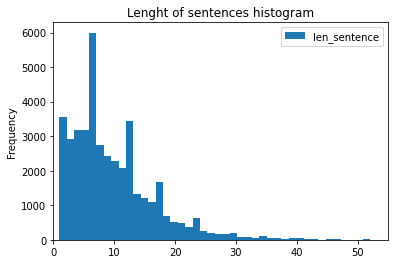

In [11]:
sentences_df[['len_sentence']].plot.hist(bins=250, xlim=(0,55), title='Lenght of sentences histogram')

In [12]:
sentences_df['len_sentence'].nlargest(5)

26455    305
28042    165
25102    148
30902    135
38086    132
Name: len_sentence, dtype: int64

Spoglądając na histogram powyżej możemy zauważyć, że większość zdań w naszym zbiorze to zdania stosunkowo krótkie – składające się najczęściej z 7-8 słów. Możemy też zaobserwować, że praktycznie większość zdań mieści się w zakresie do 50-55 słów. Natomiast patrząc na komórkę poniżej wykresu – aktualnie najdłuższym zdaniem jest wyrażenie składające się z 305 słów, później drugie składa się już z 165 a więc prawie dwa razy mniej. 

To dość ważna dla nas kwestia aby zdecydować jak maksymalnie długie zdanie będzie w naszym zbiorze, ponieważ to określi nam kształt próbki treningowej na wejściu do naszego modelu (czyli zdanie „stokeniozowane” w formie macierzy). Każda próbka, nawet jak będzie krótkim zdaniem będzie musiała mieć taki sam kształt. Większy kształt wydłuży nam czas treningu, a brakujące słowa zostaną potraktowane jako tag „O”. Zależy nam aby bardziej wykrywać tagi z nazwami własnymi, dlatego usuniemy najdłuższe zdanie z naszego zbioru i w ten sposób przyjmiemy maksymalna długość zdania jako `165`.


In [13]:
sentences_df = sentences_df[sentences_df['len_sentence'] != 305]
sentences_df[sentences_df['len_sentence'] == 305]

,zdanie,forma,etykieta,list_sentence,len_sentence,len_tag,is_equal


In [14]:
sentences_list = sentences_df['forma'].to_list()
tags_list = sentences_df['etykieta'].to_list()

In [15]:
#example sentence:
print(sentences_list[12])
print(tags_list[12])

Halina Auderska wszyscy książka kazać swój bohater szukać tożsamość
['forename', 'surname', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Dokonamy teraz tokenizacji każdego zdania. Umożliwia nam to klasa `Tokenizer` w biblibotece tensorflow.

In [16]:
tokeniser= tf.keras.preprocessing.text.Tokenizer(lower=False,filters='')

tokeniser.fit_on_texts(sentences_list)

encoded_sentence=tokeniser.texts_to_sequences(sentences_list)

In [17]:
tags = [
    "surname",
    "settlement",
    "orgName",
    "geogName",
    "addName",
    "forename",
    "persName",
    "country",
    "placeName",
    "region",
    "district",
    "bloc",
    "O",
    "date",
    "time",
]

num_tags = len(tags)


tags_map = {tag: i for i, tag in enumerate(tags)}
print("Number of Tags ", num_tags)

Number of Tags  15


In [18]:
reverse_tag_map={v: k for k, v in tags_map.items()}
reverse_tag_map

{0: 'surname',
 1: 'settlement',
 2: 'orgName',
 3: 'geogName',
 4: 'addName',
 5: 'forename',
 6: 'persName',
 7: 'country',
 8: 'placeName',
 9: 'region',
 10: 'district',
 11: 'bloc',
 12: 'O',
 13: 'date',
 14: 'time'}

In [19]:
encoded_tags=[[tags_map[w] for w in tag] for tag in tags_list]

Aby nasz trening był możliwy, muismy zrobić to o czym był już wspomniane - czyli każda nasza próbka danych musi mieć taki sam kształt:

In [20]:
max_len=165

padded_encoded_sentences=pad_sequences(maxlen=max_len,sequences=encoded_sentence,padding="post",value=0)
padded_encoded_tags=pad_sequences(maxlen=max_len,sequences=encoded_tags,padding="post",value=tags_map['O'])

In [21]:
target = [to_categorical(i,num_classes = num_tags) for i in  padded_encoded_tags]

Nasz dane są już przygotowane, możemy je teraz podzielić. Zgodnie z założeniem w zdaniu dzielimy je odpowiednio na ⁉

* dane treningowe `50%`
* dane walidacyjne `30%`
* dane testowe `20%`

In [22]:
train_ratio = 0.5
validation_ratio = 0.3
test_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    padded_encoded_sentences, target, test_size=1 - train_ratio, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_ratio / (test_ratio + validation_ratio),
    random_state=42,
)

In [23]:
print("Shape of First Sentence -Train",x_train[0].shape)
print("Shape of First Sentence Label  -Train",y_train[0].shape)

Shape of First Sentence -Train (165,)
Shape of First Sentence Label  -Train (165, 15)


# Trening

Przechodzimy do przygotowania modeli. Wykorzystujemy sieci neuronowe i bibliotekę `Keras`. Inspiracja do modeli składających się z takich warstw została zaczerpnięta z różnych tutoriali. W pierwszym kroku użujemy gotowych ustawień. Następnie spóbujemy zmodyfikować nieco parametry naszej sieci. Zobaczmy jak wygląda nasza bazowa sieć:

## model

In [24]:
embedding_dim = 165
vocab_size = len(tokeniser.word_index) + 1
lstm_units = 165
max_len = 165

input_word = Input(shape=(max_len,))
model = Embedding(
    input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=max_len
)(input_word)

model = LSTM(units=lstm_units, return_sequences=True)(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 165)]             0         
                                                                 
 embedding (Embedding)       (None, 165, 165)          8420940   
                                                                 
 lstm (LSTM)                 (None, 165, 165)          218460    
                                                                 
 time_distributed (TimeDistr  (None, 165, 15)          2490      
 ibuted)                                                         
                                                                 
Total params: 8,641,890
Trainable params: 8,641,890
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train,
    np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    batch_size=32,
    epochs=8,
)

Epoch 1/8
648/648 [==============================] - 19s 21ms/step - loss: 0.0630 - accuracy: 0.9935 - val_loss: 0.0205 - val_accuracy: 0.9955
Epoch 2/8
648/648 [==============================] - 14s 21ms/step - loss: 0.0148 - accuracy: 0.9961 - val_loss: 0.0171 - val_accuracy: 0.9961
Epoch 3/8
648/648 [==============================] - 13s 20ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0159 - val_accuracy: 0.9966
Epoch 4/8
648/648 [==============================] - 13s 20ms/step - loss: 0.0079 - accuracy: 0.9980 - val_loss: 0.0161 - val_accuracy: 0.9956
Epoch 5/8
648/648 [==============================] - 11s 17ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0137 - val_accuracy: 0.9970
Epoch 6/8
648/648 [==============================] - 11s 17ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0131 - val_accuracy: 0.9972
Epoch 7/8
648/648 [==============================] - 11s 17ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0129 - val_accuracy: 0.9973

Zakończyliśmy trening w 8 epoce z powodu rosnącej funkcji straty od 7 epoki w zbiorze walidacyjnym. Trening wyglądał poprawnie, accuracy na danych treningowych i walidacyjnych ciągle rosło, funkcja straty malała. 

Zmodyfikujemy powyższą sieć i sprawdzimy jak sobie poradzi:

## model_1

In [25]:
embedding_dim = 300
vocab_size = len(tokeniser.word_index) + 1
lstm_units = 550
max_len = 165

input_word = Input(shape=(max_len,))
model_1 = Embedding(
    input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=max_len
)(input_word)

model_1 = LSTM(units=550, return_sequences=True, dropout=0.5)(model_1)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model_1)
model_1 = Model(input_word, out)
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 165)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 165, 300)          15310800  
                                                                 
 lstm_1 (LSTM)               (None, 165, 550)          1872200   
                                                                 
 time_distributed_1 (TimeDis  (None, 165, 15)          8265      
 tributed)                                                       
                                                                 
Total params: 17,191,265
Trainable params: 17,191,265
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_1 = model_1.fit(x_train,np.array(y_train),validation_data=(x_val,np.array(y_val)),batch_size = 32,epochs = 8)

Epoch 1/8
648/648 [==============================] - 34s 49ms/step - loss: 0.0551 - accuracy: 0.9932 - val_loss: 0.0225 - val_accuracy: 0.9953
Epoch 2/8
648/648 [==============================] - 31s 48ms/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.0155 - val_accuracy: 0.9964
Epoch 3/8
648/648 [==============================] - 31s 48ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.0135 - val_accuracy: 0.9971
Epoch 4/8
648/648 [==============================] - 31s 48ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.0124 - val_accuracy: 0.9973
Epoch 5/8
648/648 [==============================] - 31s 48ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0122 - val_accuracy: 0.9971
Epoch 6/8
648/648 [==============================] - 32s 50ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0118 - val_accuracy: 0.9977
Epoch 7/8
648/648 [==============================] - 31s 48ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0121 - val_accuracy: 0.9977

Zmodyfikowaliśmy warstwę LSTM, a w niej:

* zwiększyliśmy liczbę jednostek w parametrze `units` do `550`
* dodaliśmy parametr `dropout` ustawiony na `0.5`

Na pierwszy rzut oka udało się nam osiągnąć nieco lepsze wyniki, jedank zweryfikujemy to na końcu.

In [33]:
def plot_trenning_results(model_name, model_history):
    plt.plot(model_history.history["accuracy"])
    plt.plot(model_history.history["val_accuracy"])
    plt.title(f"{model_name} accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

    plt.plot(model_history.history["loss"])
    plt.plot(model_history.history["val_loss"])
    plt.title(f"{model_name} loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

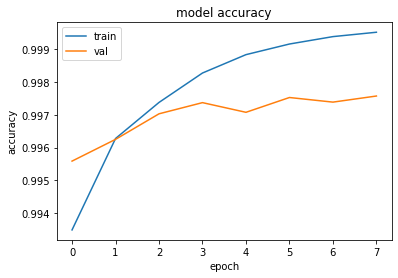

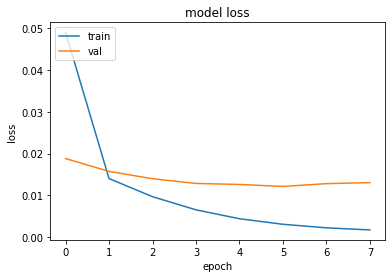

In [34]:
plot_trenning_results('model', history)

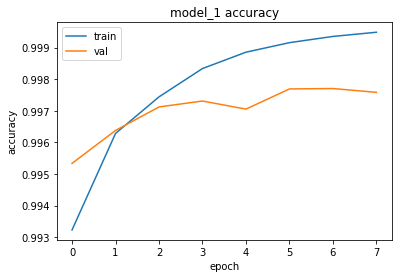

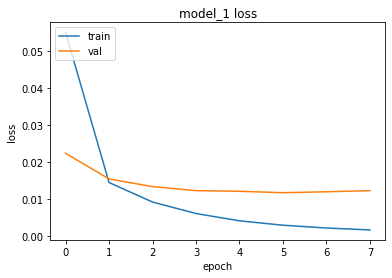

In [35]:
plot_trenning_results('model_1', history_1)

Powyżej możemy dokładnie zobaczyć jak przebiegał trening obu modeli.

In [36]:
print('model:')
model.evaluate(x_test, np.array(y_test))

model:
259/259 [==============================] - 2s 6ms/step - loss: 0.0138 - accuracy: 0.9973


[0.013766448013484478, 0.9973046183586121]

In [37]:
print('model_1:')
model_1.evaluate(x_test, np.array(y_test))

model_1:
259/259 [==============================] - 4s 14ms/step - loss: 0.0127 - accuracy: 0.9975


[0.012656353414058685, 0.9975488185882568]

Po ewaluacji `model_1` osiąganł lepszy wynik. Accuracy jest większe, a funkcja straty mniejsza.

In [38]:
preds=model.predict(x_test)
preds_1=model_1.predict(x_test)

259/259 [==============================] - 3s 12ms/step


Funkcja `evaluate_predictions` pomoże nam zamienić nasze predykcje na zbiory które będziemy mogli wykorzystać do stworzenia raportu z ostatecznymi wynikami.

In [39]:
def evaluate_predictions(test_data, preds, actual_preds):    
    print("Shape of Test Data Array", test_data.shape)
    y_actual = np.argmax(np.array(actual_preds), axis=2)
    y_pred = np.argmax(preds, axis=2)
    num_test_data = test_data.shape[0]
    print("Number of Test Data Points ", num_test_data)
    data = pd.DataFrame()
    df_list = []
    for i in range(num_test_data):
        test_str = list(test_data[i])
        df = pd.DataFrame()
        df["test_tokens"] = test_str
        df["tokens"] = df["test_tokens"].apply(
            lambda x: tokeniser.index_word[x] if x != 0 else "<PAD>"
        )
        df["actual_target_index"] = list(y_actual[i])
        df["pred_target_index"] = list(y_pred[i])
        df["actual_target_tag"] = df["actual_target_index"].apply(
            lambda x: reverse_tag_map[x]
        )
        df["pred_target_tag"] = df["pred_target_index"].apply(
            lambda x: reverse_tag_map[x]
        )
        df["id"] = i + 1
        df_list.append(df)
    data = pd.concat(df_list)
    pred_data = data[data["tokens"] != "<PAD>"]
    accuracy = (
        pred_data[pred_data["actual_target_tag"] == pred_data["pred_target_tag"]].shape[
            0
        ]
        / pred_data.shape[0]
    )

    return pred_data, accuracy

In [40]:
pred_data ,accuracy = evaluate_predictions(x_test,preds,y_test)
pred_data_1 ,accuracy_1 = evaluate_predictions(x_test,preds_1,y_test)

Shape of Test Data Array (8288, 165)
Number of Test Data Points  8288
Shape of Test Data Array (8288, 165)
Number of Test Data Points  8288


Stworzymy drugi model

Tym razem podejdziemy bardzo kreatywnie i sprawdzimy czy więcej warstw w naszym modelu pomoże w osiągnięciu lepszych wyników.

Dołożymy dodatkową warstwę `LSTM`

Wiemy już że zwiększenie jednostek `units` a także dodanie `dropout` bardzo pomaga. 

## model_2

In [62]:
embedding_dim = 165
vocab_size=len(tokeniser.word_index)+1
lstm_units=500
max_len=165

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_units, activation='tanh', return_sequences=True, dropout=0.25)),    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_units, activation='tanh', return_sequences=True, dropout=0.25)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_2 = model_2.fit(x_train,np.array(y_train),validation_data=(x_val,np.array(y_val)),batch_size = 32,epochs = 4)

Epoch 1/4
648/648 [==============================] - 114s 168ms/step - loss: 0.0333 - accuracy: 0.9937 - val_loss: 0.0162 - val_accuracy: 0.9959
Epoch 2/4
648/648 [==============================] - 107s 166ms/step - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.0139 - val_accuracy: 0.9965
Epoch 3/4
648/648 [==============================] - 107s 165ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0130 - val_accuracy: 0.9969
Epoch 4/4
648/648 [==============================] - 107s 165ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0135 - val_accuracy: 0.9968


In [64]:
model_2.evaluate(x_test, np.array(y_test))

259/259 [==============================] - 13s 50ms/step - loss: 0.0136 - accuracy: 0.9968


[0.01356450468301773, 0.9968336820602417]

In [65]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 165, 165)          8420940   
                                                                 
 bidirectional_4 (Bidirectio  (None, 165, 1000)        2664000   
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 165, 1000)        6004000   
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 165, 15)          15015     
 tributed)                                                       
                                                                 
Total params: 17,103,955
Trainable params: 17,103,955
Non-trainable params: 0
__________________________________________

In [71]:
preds_2=model_2.predict(x_test)

pred_data_2 ,accuracy_2 =evaluate_predictions(x_test,preds_2,y_test)

259/259 [==============================] - 13s 49ms/step
Shape of Test Data Array (8288, 165)
Number of Test Data Points  8288


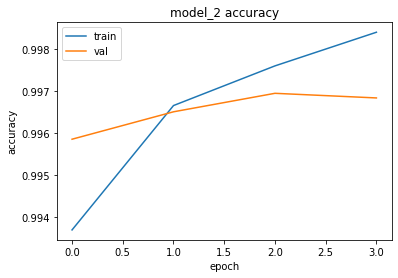

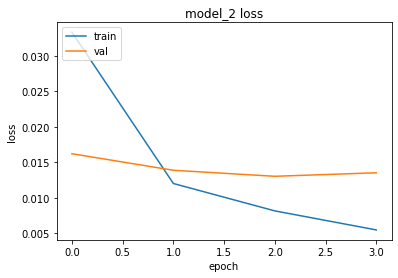

In [66]:
plot_trenning_results('model_2', history_2)

Trening przebiagł znacznie słabiej niż we wcześnijszych modelach. Musieliśmy go już zakończyć w 4 epoce, ponieważ accuracy na zbiorze walidacyjnym bardzo szybko zaczęło spadać a loss rosnąć. Możemy już stwierdzić, że dołożenie kolejnych warstw nie jest dobrym pomysłem.

# Wyniki wszystkich modeli - raport klasyfikacji

Na końcu sprawdźmy dokładnie co udało się nam osiągnąć implementując każdy model. Wiemy już jak przebiagał trening każdego z modeli.

Po ewaluacji każdy z modeli osiąganł:

* `model` : loss `0.0138` - accuracy: `0.9973`
* `model_1` : loss `0.0127` - accuracy: `0.9975`
* `model_2` : loss `0.0136` - accuracy: `0.9968`

Zobaczymy raport klasyfikacji dla każdego modelu:

In [68]:
y_pred = pred_data['pred_target_tag'].tolist()
y_actual = pred_data['actual_target_tag'].tolist()

print('classification_report for: model')
print(classification_report(y_actual,y_pred))

classification_report for: model
              precision    recall  f1-score   support

           O       0.97      0.99      0.98     75548
     addName       0.53      0.16      0.25        97
        bloc       0.00      0.00      0.00        16
     country       0.90      0.83      0.86       908
        date       0.68      0.51      0.59       402
    district       0.58      0.19      0.29        37
    forename       0.83      0.75      0.79      1437
    geogName       0.57      0.47      0.52       447
     orgName       0.53      0.51      0.52      1115
    persName       0.76      0.54      0.64       101
   placeName       1.00      0.24      0.39        29
      region       0.08      0.35      0.12        49
  settlement       0.87      0.59      0.70       801
     surname       0.84      0.64      0.73      1462
        time       1.00      0.05      0.09        44

    accuracy                           0.96     82493
   macro avg       0.68      0.45      0.50    

In [69]:
y_pred_1 = pred_data_1['pred_target_tag'].tolist()
y_actual_1 = pred_data_1['actual_target_tag'].tolist()

print('classification_report for: model_1')
print(classification_report(y_actual_1,y_pred_1))

classification_report for: model_1
              precision    recall  f1-score   support

           O       0.97      0.99      0.98     75548
     addName       0.50      0.21      0.29        97
        bloc       0.33      0.12      0.18        16
     country       0.94      0.83      0.88       908
        date       0.67      0.58      0.62       402
    district       0.50      0.16      0.24        37
    forename       0.95      0.74      0.84      1437
    geogName       0.39      0.56      0.46       447
     orgName       0.65      0.49      0.56      1115
    persName       0.72      0.63      0.67       101
   placeName       0.65      0.52      0.58        29
      region       0.50      0.29      0.36        49
  settlement       0.92      0.57      0.70       801
     surname       0.82      0.68      0.75      1462
        time       0.61      0.39      0.47        44

    accuracy                           0.96     82493
   macro avg       0.68      0.52      0.57  

In [72]:
y_pred_2 = pred_data_2['pred_target_tag'].tolist()
y_actual_2 = pred_data_2['actual_target_tag'].tolist()

print('classification_report for: model_2')
print(classification_report(y_actual_2,y_pred_2))

classification_report for: model_2
              precision    recall  f1-score   support

           O       0.98      0.98      0.98     75548
     addName       0.00      0.00      0.00        97
        bloc       0.00      0.00      0.00        16
     country       0.90      0.84      0.87       908
        date       0.22      0.63      0.32       402
    district       0.00      0.00      0.00        37
    forename       0.92      0.73      0.81      1437
    geogName       0.29      0.38      0.33       447
     orgName       0.48      0.52      0.50      1115
    persName       0.88      0.07      0.13       101
   placeName       0.00      0.00      0.00        29
      region       0.00      0.00      0.00        49
  settlement       0.69      0.55      0.61       801
     surname       0.86      0.54      0.66      1462
        time       0.00      0.00      0.00        44

    accuracy                           0.95     82493
   macro avg       0.41      0.35      0.35  

Ostatecznie raport też potwierdza, że `model_1` pordzaił sobie lepiej. Z racji 15 klas ciężko go dokładnie porównać, ale najlepszym odnisieniem będzie wynik w miarze `f1` macro avg. 

Dla każdego z modeli wygląda to następująco:

 * `model` z wynikiem `0.50`
 * `model_1` z wynikiem `0.57`
 * `model_1` z wynikiem `0.35`

A więc najlepiej wygląda `model_1`

Zobaczymy jeszcze jak poradził sobie `model_1`. Najlepiej poszło mu w predykcji klasy `forname`, najgorzej w klasie `bloc`. Zobaczmy jak wyglądała predykcja w klasie `bloc`.

In [73]:
pred_data_1[(pred_data_1['actual_target_tag']=="bloc")].head(10)

,test_tokens,tokens,actual_target_index,pred_target_index,actual_target_tag,pred_target_tag,id
8,546,unia,11,2,bloc,orgName,285
2,336,Europa,11,3,bloc,geogName,2097
6,414,europejski,11,3,bloc,geogName,3389
11,414,europejski,11,3,bloc,geogName,4093
13,1484,NATO,11,2,bloc,orgName,4093
15,336,Europa,11,3,bloc,geogName,4742
13,6288,Układu,11,11,bloc,bloc,5455
27,6288,Układu,11,11,bloc,bloc,5455
14,546,unia,11,2,bloc,orgName,5502
15,414,europejski,11,3,bloc,geogName,5502
